For this use case, we start with the Satellogic dataset https://satellogic-earthview.s3.us-west-2.amazonaws.com/index.html

The dataset is located in a public AWS S3 bucket.

We can retrieve the metadata from the dataset in the form of a parquet file using the following command:

In [ ]:
# !curl -O https://satellogic-earthview.s3.us-west-2.amazonaws.com/colab/satellogic-earthview-items.parquet

In [3]:
import geopandas as gpd

gdf = gpd.read_parquet('satellogic-earthview-items.parquet')

In [31]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 7095985 entries, 0 to 7095984
Data columns (total 5 columns):
 #   Column     Dtype         
---  ------     -----         
 0   json_path  object        
 1   zone       object        
 2   region     object        
 3   date       datetime64[ns]
 4   geometry   geometry      
dtypes: datetime64[ns](1), geometry(1), object(3)
memory usage: 324.8+ MB


In [32]:
gdf.head()

,json_path,zone,region,date,geometry
0,data/json/zone=04N/region=603411_2346301/date=...,04N,603411_2346301,2022-09-15,"POLYGON ((-157.99991 21.21181, -157.99988 21.2..."
1,data/json/zone=04N/region=603411_2346685/date=...,04N,603411_2346685,2022-09-15,"POLYGON ((-157.99988 21.21528, -157.99986 21.2..."
2,data/json/zone=04N/region=603411_2347069/date=...,04N,603411_2347069,2022-09-15,"POLYGON ((-157.99986 21.21875, -157.99984 21.2..."
3,data/json/zone=04N/region=603411_2347453/date=...,04N,603411_2347453,2022-09-15,"POLYGON ((-157.99984 21.22221, -157.99981 21.2..."
4,data/json/zone=04N/region=603411_2347837/date=...,04N,603411_2347837,2022-09-15,"POLYGON ((-157.99981 21.22568, -157.99979 21.2..."


Each row in the parquet file corresponds to a satellite image, which metadata is stored in a separate json file.

The json files can be downloaded using the following command (it will take a while):

In [1]:
#!s5cmd --endpoint-url https://s3.us-west-2.amazonaws.com --no-sign-request cp 's3://satellogic-earthview/data/*' data > /dev/null 2>&1

In [4]:
gdf.iloc[0].json_path

'data/json/zone=04N/region=603411_2346301/date=2022-09-15/20220915_010014_SN20_04N_603411_2346301_metadata.json'

In [5]:
import json

with open(gdf.iloc[0].json_path, 'r') as f:
    metadata = json.load(f)

metadata


{'id': '20220915_010014_SN20_04N_603411_2346301',
 'type': 'Feature',
 'properties': {'gsd': 1.0,
  'proj:epsg': '32604',
  'platform': 'newsat20',
  'grid:code': '04N-603411_2346301',
  'satl:altitude': 456.8651464515633,
  'satl:altitude_units': 'km',
  'satl:product_name': 'L1',
  'view:azimuth': 97.1382808902086,
  'view:off_nadir': 19.474754820772176,
  'view:sun_azimuth': 249.34650770444287,
  'view:sun_elevation': 48.67771372102758,
  'license': 'CC-BY-4.0',
  'datetime': '2022-09-15T01:00:14.573735+00:00',
  'providers': [{'name': 'Satellogic',
    'roles': ['processor', 'producer', 'licensor'],
    'url': 'https://www.satellogic.com'},
   {'name': 'Amazon Web Services',
    'description': 'AWS Open Data Sponsorship Program, hosting the dataset.',
    'roles': ['host'],
    'url': 'https://registry.opendata.aws/'}],
  'proj:shape': [384, 384],
  'proj:transform': [1.0, 0.0, 603411.0, 0.0, -1.0, 2346301.0, 0.0, 0.0, 1.0]},
 'links': [{'rel': 'parent',
   'type': 'application/jso

For each image we can extract the provider

In [6]:
metadata['properties']['providers']

[{'name': 'Satellogic',
  'roles': ['processor', 'producer', 'licensor'],
  'url': 'https://www.satellogic.com'},
 {'name': 'Amazon Web Services',
  'description': 'AWS Open Data Sponsorship Program, hosting the dataset.',
  'roles': ['host'],
  'url': 'https://registry.opendata.aws/'}]

And the images (preview, visual, analytics or thumbnail)

In [7]:
metadata['assets']

{'preview': {'href': 'https://satellogic-earthview.s3.us-west-2.amazonaws.com/data/png/zone=04N/region=603411_2346301/date=2022-09-15/20220915_010014_SN20_04N_603411_2346301_preview.png',
  'type': 'image/png',
  'roles': ['overview']},
 'visual': {'href': 'https://satellogic-earthview.s3.us-west-2.amazonaws.com/data/tif/zone=04N/region=603411_2346301/date=2022-09-15/20220915_010014_SN20_04N_603411_2346301_VISUAL.tif',
  'type': 'image/tiff; application=geotiff; profile=cloud-optimized',
  'roles': ['data', 'visual'],
  'eo:bands': [{'name': 'Red', 'common_name': 'red'},
   {'name': 'Green', 'common_name': 'green'},
   {'name': 'Blue', 'common_name': 'blue'},
   {'name': 'NIR', 'common_name': 'nir'}]},
 'analytic': {'href': 'https://satellogic-earthview.s3.us-west-2.amazonaws.com/data/tif/zone=04N/region=603411_2346301/date=2022-09-15/20220915_010014_SN20_04N_603411_2346301_TOA.tif',
  'type': 'image/tiff; application=geotiff; profile=cloud-optimized',
  'roles': ['data', 'reflectance'

In [8]:
import rasterio as rio 

x = rio.open(metadata['assets']['visual']['href']).read()
x.shape, x.dtype, x.min(), x.max()


((3, 384, 384), dtype('uint8'), np.uint8(0), np.uint8(241))

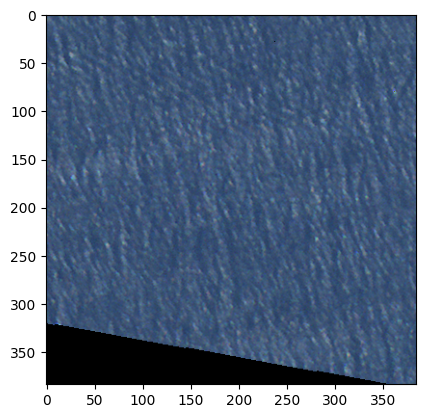

In [10]:
import matplotlib.pyplot as plt

plt.imshow(x.transpose(1, 2, 0))
plt.show()

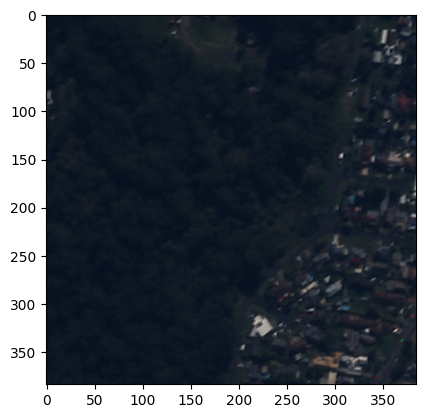

In [36]:
import numpy as np

def plot_random_image(metadata):
    ix = np.random.randint(0, len(gdf))
    with open(gdf.iloc[ix].json_path, 'r') as f:
    	metadata = json.load(f)
    x = rio.open(metadata['assets']['visual']['href']).read()
    plt.imshow(x.transpose(1, 2, 0))
    plt.show()

plot_random_image(metadata)